In [ ]:
# default_exp funcs.merfish_codenet

In [ ]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

In [ ]:
# export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
import torch.nn as nn
import torch.nn.functional as F
from decode_fish.funcs.predict import *

from omegaconf import open_dict
from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *

from decode_fish.engine.point_process import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.matching import *
from decode_fish.engine.gmm_loss import *
from decode_fish.engine.microscope import add_pos_noise
from sklearn.utils import resample
import wandb

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_9/z_facs:Falsexnorm:none//train.yaml')
cfg = OmegaConf.load('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_35/image_path:scaled4_images47//train.yaml')

In [ ]:
from decode_fish.funcs.exp_specific import *
codebook, targets = hydra.utils.instantiate(cfg.codebook)

In [ ]:
# test_csv = pd.read_csv('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/qual_nets/starfish_test.csv')
test_csv = pd.read_csv('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/qual_nets/mop_47_test.csv')
# test_csv['int_ratio'] = zero_int_ch(test_csv, codebook)['int_ratio']

In [ ]:
cfg.genm.foci.n_foci_avg = 0
cfg.training.bs = 20
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/psf.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)


Crop size larger than volume in at least one dimension. Crop size changed to (1, 56, 56)
7 volumes


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
post_proc.codebook = expand_codebook(codebook)

In [ ]:
# export
class code_net(nn.Module):

    def __init__(self, n_inputs=9, n_outputs=1):
        super(code_net, self).__init__()
        
        self.layers = nn.Sequential(
          nn.Linear(n_inputs, 256),
          nn.ReLU(),
          nn.Linear(256, 128),
          nn.ReLU(),
          nn.Linear(128, 64),
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.ReLU(),
          nn.Linear(32, n_outputs)
        )
        
    def forward(self, x):
        
        return self.layers(x)
    
class conv_net(nn.Module):

    def __init__(self, n_metrics=5, n_chs=16, bn=False):
        super(conv_net, self).__init__()
    
        self.n_chs = n_chs
        self.n_metrics = n_metrics

        self.int_c1 = nn.Linear(3, 10).cuda()
        self.int_c2 = nn.Linear(10, 10).cuda()
        self.int_c3 = nn.Linear(10, 1).cuda()
        
        if bn:
            self.layers = nn.Sequential(
              nn.Linear(self.n_metrics + self.n_chs, 256),
              nn.BatchNorm1d(256),
              nn.ReLU(),
              nn.Linear(256, 128),
              nn.BatchNorm1d(128),
              nn.ReLU(),
              nn.Linear(128, 64),
              nn.BatchNorm1d(64),
              nn.ReLU(),
              nn.Linear(64, 32),
              nn.BatchNorm1d(32),
              nn.ReLU(),
              nn.Linear(32, 1)
            )
        else:
            self.layers = nn.Sequential(
              nn.Linear(self.n_metrics + self.n_chs, 256),
              nn.ReLU(),
              nn.Linear(256, 128),
              nn.ReLU(),
              nn.Linear(128, 64),
              nn.ReLU(),
              nn.Linear(64, 32),
              nn.ReLU(),
              nn.Linear(32, 1)
            )            
        
    def forward(self, x):
        
        intm_ints_bin = x[:, -3*self.n_chs:].reshape(-1, 3, self.n_chs).permute(0,2,1)
        f_int = F.relu(self.int_c1(intm_ints_bin))
        f_int = F.relu(self.int_c2(f_int))
        f_int = F.relu(self.int_c3(f_int)[:,:,0])
        
        dense_inp = torch.cat([x[:, :self.n_metrics], f_int], 1)
        return self.layers(dense_inp)   

# net = code_net().cuda()
net = conv_net(6, 16).cuda()

def input_from_df(df, codebook):
          
    n_ch = len(codebook[0])
    input_keys = ['prob', 'z', 'x_sig','y_sig','z_sig','int_ratio'] + [f'int_sig_{i}' for i in range(n_ch)]  + [f'int_{i}' for i in range(n_ch)]
    offsets = [0.75, 50, 20., 20., 15.,2.] + n_ch*[1.] + n_ch*[0.]
    scales = [1., 100., 20., 20., 15.,2.] + n_ch*[2.] + n_ch*[5.]
    inp_arr = df[input_keys].values
    inp_arr = (inp_arr - np.array(offsets))/np.array(scales)
    
    inp_arr = np.concatenate([inp_arr, codebook[df['code_inds'].values]], 1)
    
    return torch.tensor(inp_arr, dtype=torch.float32).cuda()

# def input_from_df(df, codebook):
          
#     n_ch = len(codebook[0])
#     input_keys = ['prob', 'z', 'x_sig','y_sig','z_sig','int_ratio','tot_int','tot_int_0bit','tot_int_sig'] 
#     offsets = [0.75, 50, 20., 20., 15.,2.,10.,10.,5.]
#     scales = [1., 100., 20., 20., 15.,2.,10.,10.,5.]
#     inp_arr = df[input_keys].values
#     inp_arr = (inp_arr - np.array(offsets))/np.array(scales)
    
#     return torch.tensor(inp_arr, dtype=torch.float32).cuda()

In [ ]:
# export
def train_metric_net(net, model, decode_dl, post_proc, micro, point_process, cfg):

    bce = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([cfg.pos_weight]).cuda())
    opt = torch.optim.AdamW(net.parameters(), lr = 4e-3)
    sched = torch.optim.lr_scheduler.StepLR(opt, step_size=100, gamma=0.5)
    test_csv = pd.read_csv(cfg.test_csv)
    codebook, targets = hydra.utils.instantiate(cfg.codebook)
    model.cuda()
    test_csv['int_ratio'] = sel_int_ch(test_csv, codebook)['int_ratio']
    
    ignores = [int(a) for a in str(cfg.ignore)]
    zero_out = torch.ones(9).cuda()
    zero_out[ignores] = 0
    
    for i in tqdm(range(cfg.num_iters)):

        with torch.no_grad():

            ret_dict = next(iter(decode_dl))
            x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'],
            zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
            background = background * micro.get_ch_mult()
            if cfg.sim.bg_estimation.shuffle_ch:
                background = background.index_select(1, torch.randperm(background.shape[1]).cuda())

            if cfg.genm.microscope.col_shifts_enabled  :
                zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
                zcrop, ycrop, xcrop = zcrop.flatten(), ycrop.flatten(), xcrop.flatten()
                colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
            else:
                zcrop, ycrop, xcrop, colshift_crop = None, None, None, None

            local_rate *= cfg.rate_fac
            sim_vars = point_process.sample(local_rate[:,0])

            ch_inp = list(micro.get_single_ch_inputs(*sim_vars[:-1], ycrop=ycrop, xcrop=xcrop))
            cond = sim_vars[-1] < len(codebook)
            cb_cool = torch.repeat_interleave(cond, cond * (cfg.genm.exp_type.n_bits - 1) + 1)
            ch_inp[1][cb_cool], ch_inp[2][cb_cool], ch_inp[3][cb_cool] = add_pos_noise([ch_inp[1][cb_cool], ch_inp[2][cb_cool], ch_inp[3][cb_cool]],
                                                                                       [cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_z], cfg.genm.exp_type.n_bits)
            xsim = micro(*ch_inp, add_noise=True)

            if cfg.genm.phasing:

                phasing_inp = list(micro.get_single_ch_inputs(*sim_vars[:4], get_phased_ints(sim_vars[4], micro.ch_cols, micro.psf.n_cols) ,sim_vars[5], ycrop=ycrop, xcrop=xcrop))
                phasing_inp[1:4] = add_pos_noise(phasing_inp[1:4], [cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_z], cfg.genm.exp_type.n_bits, rm_mean=False)
                xsim += micro(*phasing_inp, add_noise=True) * cfg.genm.phasing * torch.rand(xsim.shape, device=xsim.device)

            x = micro.noise(xsim, background, randomize_range=cfg.genm.exp_type.randomize_noise_range).sample()

            colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
            net_inp = torch.concat([x,colshift_crop], 1)

            gt_vars = sim_vars[:-2]
            gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])
            gt_df = gt_df[gt_df['code_inds'] < len(codebook)]

            res_dict = model(net_inp.cuda())
            res_dict = model.tensor_to_dict(res_dict)
            pred_df = post_proc.get_df(res_dict)
            pred_df = pred_df[pred_df['code_inds'] < len(codebook)]
            pred_df['gene'] = targets[pred_df['code_inds']]
    #         pred_df = sel_int_ch(pred_df, codebook)

            perf, matches, _ = matching(px_to_nm(gt_df), pred_df, tolerance=500, print_res=False)

            pred_df.loc[:, 'class'] = 1
            pred_df.loc[pred_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0
            pred_zeroed = zero_int_ch(pred_df, codebook)
            pred_df['int_ratio'] = pred_zeroed['int_ratio'].values
            pred_df['tot_int'] = pred_zeroed['tot_int'].values
            pred_df['tot_int_0bit'] = pred_zeroed['tot_int_0bit'].values
            pred_df['tot_int_sig'] = pred_zeroed['tot_int_sig'].values
            
        opt.zero_grad()

        ''''''
        if cfg.resample:
            df_majority = pred_df[pred_df['class']==0]
            df_minority = pred_df[pred_df['class']==1]

            df_maj_down = resample(df_majority, replace=True, n_samples=len(df_minority)*2)

            pred_df = pd.concat([df_minority, df_maj_down])
        ''''''

        net_inp = input_from_df(pred_df, codebook)
#         net_inp *= zero_out[None]
        net_out = net(net_inp)

        net_tar = torch.tensor(pred_df['class'].values, dtype=torch.float32).cuda()
        loss = bce(net_out, net_tar[:,None])

        test_csv['net_score'] = torch.sigmoid(net(input_from_df(test_csv, codebook)).detach().cpu())

        loss.backward()

        opt.step()
        sched.step()

        wandb.log({'loss': loss.item()}, step=i)
#         wandb.log({'NN_blanks': test_csv.nsmallest(12555, 'net_score')['class'].sum()}, step=i)
        wandb.log({'NN_blanks': test_csv.nsmallest(64252, 'net_score')['class'].sum()/88}, step=i)
        wandb.log({'NN_preds': (test_csv.sort_values('net_score', ascending=True)['class'].cumsum().values <= 88).sum()/64252}, step=i)
        if i % 20 == 0 and cfg.save_file is not None:
            torch.save(net, cfg.save_file)
            
    wandb.finish()

In [ ]:
net = conv_net(6, 16).cuda()
net = code_net(9).cuda()

In [ ]:
num_iters = 500
i = 0

micro.psf_noise = 0.0

bce = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10]).cuda())
opt = torch.optim.AdamW(net.parameters(), lr = 4e-3)
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=100, gamma=0.5)
loss_col = []

model.eval().cuda()

code_weight = torch.ones(len(post_proc.codebook))
code_weight[len(codebook):] *= cfg.genm.emitter_noise.rate_fac
point_process = PointProcessUniform(int_conc=cfg.genm.intensity_dist.int_conc, int_rate=cfg.genm.intensity_dist.int_rate, int_loc=cfg.genm.intensity_dist.int_loc, 
                                   sim_iters=5, n_channels=cfg.genm.exp_type.n_channels, sim_z=cfg.genm.exp_type.pred_z, slice_rec=cfg.genm.exp_type.slice_rec, 
                                   codebook=post_proc.codebook, int_option=cfg.training.int_option, code_weight=code_weight)

zero_out = torch.ones(72).cuda()
zero_out[5] = 0

for i in tqdm(range(num_iters)):

    with torch.no_grad():

        ret_dict = next(iter(decode_dl))
        x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'], 
        zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
        background = background * micro.get_ch_mult()
        if cfg.sim.bg_estimation.shuffle_ch:
            background = background.index_select(1, torch.randperm(background.shape[1]).cuda())
        
        local_rate *= 4.
        if cfg.genm.microscope.col_shifts_enabled  :
            zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
            zcrop, ycrop, xcrop = zcrop.flatten(), ycrop.flatten(), xcrop.flatten()
            colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
        else:
            zcrop, ycrop, xcrop, colshift_crop = None, None, None, None

        sim_vars = point_process.sample(local_rate[:,0])
        
        ch_inp = list(micro.get_single_ch_inputs(*sim_vars[:-1], ycrop=ycrop, xcrop=xcrop))
        cond = sim_vars[-1] < len(codebook)
        cb_cool = torch.repeat_interleave(cond, cond * (cfg.genm.exp_type.n_bits - 1) + 1)
        ch_inp[1][cb_cool], ch_inp[2][cb_cool], ch_inp[3][cb_cool] = add_pos_noise([ch_inp[1][cb_cool], ch_inp[2][cb_cool], ch_inp[3][cb_cool]], 
                                                                                   [cfg.genm.pos_noise.pos_noise_xy*0.5, cfg.genm.pos_noise.pos_noise_xy*0.5, cfg.genm.pos_noise.pos_noise_z], cfg.genm.exp_type.n_bits)
        xsim = micro(*ch_inp, add_noise=True)
        
        if cfg.genm.phasing:

            phasing_inp = list(micro.get_single_ch_inputs(*sim_vars[:4], get_phased_ints(sim_vars[4], micro.ch_cols, micro.psf.n_cols) ,sim_vars[5], ycrop=ycrop, xcrop=xcrop))
            phasing_inp[1:4] = add_pos_noise(phasing_inp[1:4], [cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_z], cfg.genm.exp_type.n_bits, rm_mean=False)
            xsim += micro(*phasing_inp, add_noise=True) * cfg.genm.phasing * torch.rand(xsim.shape, device=xsim.device)

        x = micro.noise(xsim, background, randomize_range=cfg.genm.exp_type.randomize_noise_range).sample()

        colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
        net_inp = torch.concat([x,colshift_crop], 1)
        
        gt_vars = sim_vars[:-2] 
        gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])
        gt_df = gt_df[gt_df['code_inds'] < len(codebook)]

        res_dict = model(net_inp.cuda())
        res_dict = model.tensor_to_dict(res_dict)
        pred_df = post_proc.get_df(res_dict)
        pred_df = pred_df[pred_df['code_inds'] < len(codebook)]
        pred_df['gene'] = targets[pred_df['code_inds']]
#         pred_df = sel_int_ch(pred_df, codebook)
        
        perf, matches, _ = matching(px_to_nm(gt_df), pred_df, tolerance=500, print_res=False)
        
        pred_df.loc[:, 'class'] = 1
        pred_df.loc[pred_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0
        pred_zeroed = zero_int_ch(pred_df, codebook)
        pred_df['int_ratio'] = pred_zeroed['int_ratio'].values
        pred_df['tot_int'] = pred_zeroed['tot_int'].values
        pred_df['tot_int_0bit'] = pred_zeroed['tot_int_0bit'].values
        pred_df['tot_int_sig'] = pred_zeroed['tot_int_sig'].values

    opt.zero_grad()

    ''''''
#     df_majority = pred_df[pred_df['class']==0]
#     df_minority = pred_df[pred_df['class']==1]

#     df_maj_down = resample(df_majority, replace=True, n_samples=len(df_minority)*2)

#     pred_df = pd.concat([df_minority, df_maj_down])    
    ''''''
    
    net_inp = input_from_df(pred_df, codebook)
#     net_inp *= zero_out[None]
    net_out = net(net_inp)

    net_tar = torch.tensor(pred_df['class'].values, dtype=torch.float32).cuda()
    loss = bce(net_out, net_tar[:,None])
    print(loss.item())
    
    test_csv['net_score'] = torch.sigmoid(net(input_from_df(test_csv, codebook)).detach().cpu())
#     print(test_csv.nsmallest(12555, 'net_score')['class'].sum())
    print('NN_blanks', test_csv.nsmallest(64252, 'net_score')['class'].sum()/88)
    print('NN_preds', (test_csv.sort_values('net_score', ascending=True)['class'].cumsum().values <= 88).sum()/64252)

    torch.save(net, '../data/qual_nets/net1.pkz')

    loss.backward()

    opt.step()
    sched.step()

    loss_col.append(loss.item())

  0%|▎                                                                                                                                                 | 1/500 [00:08<1:14:21,  8.94s/it]

1.633864402770996
NN_blanks 4.420454545454546
NN_preds 0.05069102907302497


  0%|▌                                                                                                                                                 | 2/500 [00:18<1:19:10,  9.54s/it]

1.6851027011871338
NN_blanks 0.42045454545454547
NN_preds 1.1434819149598456


  1%|▉                                                                                                                                                 | 3/500 [00:27<1:14:21,  8.98s/it]

1.4513185024261475
NN_blanks 0.4318181818181818
NN_preds 1.1358401294901326


  1%|█▏                                                                                                                                                | 4/500 [00:35<1:12:23,  8.76s/it]

1.3579930067062378
NN_blanks 0.4431818181818182
NN_preds 1.1376143933262777


  1%|█▍                                                                                                                                                | 5/500 [00:45<1:14:30,  9.03s/it]

1.379210114479065
NN_blanks 0.4090909090909091
NN_preds 1.1473728444250764


  1%|█▊                                                                                                                                                | 6/500 [00:56<1:20:58,  9.84s/it]

1.393174409866333
NN_blanks 0.36363636363636365
NN_preds 1.1581896283384174


  1%|██                                                                                                                                                | 7/500 [01:09<1:27:54, 10.70s/it]

1.3811277151107788
NN_blanks 0.36363636363636365
NN_preds 1.165131046504389


  2%|██▎                                                                                                                                               | 8/500 [01:22<1:33:45, 11.43s/it]

1.3865987062454224
NN_blanks 0.3522727272727273
NN_preds 1.1725082487704663


  2%|██▋                                                                                                                                               | 9/500 [01:33<1:34:02, 11.49s/it]

1.3516132831573486
NN_blanks 0.32954545454545453
NN_preds 1.176757143746498


  2%|██▉                                                                                                                                              | 10/500 [01:46<1:37:32, 11.94s/it]

1.3970621824264526
NN_blanks 0.32954545454545453
NN_preds 1.1817686608977152


  2%|███▏                                                                                                                                             | 11/500 [01:58<1:36:52, 11.89s/it]

1.3087025880813599
NN_blanks 0.3181818181818182
NN_preds 1.183231650376642


  2%|███▍                                                                                                                                             | 12/500 [02:10<1:36:54, 11.92s/it]

1.347165822982788
NN_blanks 0.29545454545454547
NN_preds 1.183854199091079


  3%|███▊                                                                                                                                             | 13/500 [02:22<1:36:28, 11.89s/it]

1.3401196002960205
NN_blanks 0.2840909090909091
NN_preds 1.1881186577849716


  3%|████                                                                                                                                             | 14/500 [02:33<1:34:17, 11.64s/it]

1.3306161165237427
NN_blanks 0.2840909090909091
NN_preds 1.1902041959783354


  3%|████▎                                                                                                                                            | 15/500 [02:44<1:33:02, 11.51s/it]

1.2951453924179077
NN_blanks 0.29545454545454547
NN_preds 1.1932546846790761


  3%|████▋                                                                                                                                            | 16/500 [02:55<1:32:32, 11.47s/it]

1.2969824075698853
NN_blanks 0.2840909090909091
NN_preds 1.1947021104401419


  3%|████▉                                                                                                                                            | 17/500 [03:07<1:33:20, 11.59s/it]

1.300546646118164
NN_blanks 0.25
NN_preds 1.197721471705161


  4%|█████▏                                                                                                                                           | 18/500 [03:19<1:33:06, 11.59s/it]

1.2687371969223022
NN_blanks 0.23863636363636365
NN_preds 1.1988731868268692
1.207198143005371
NN_blanks 0.22727272727272727
NN_preds 1.2024528419348814


  4%|█████▊                                                                                                                                           | 20/500 [03:43<1:35:53, 11.99s/it]

1.3063465356826782
NN_blanks 0.2159090909090909
NN_preds 1.2060947519143372


  4%|██████                                                                                                                                           | 21/500 [03:55<1:34:36, 11.85s/it]

1.216399908065796
NN_blanks 0.20454545454545456
NN_preds 1.2072620307539066


  4%|██████▍                                                                                                                                          | 22/500 [04:06<1:34:15, 11.83s/it]

1.2492157220840454
NN_blanks 0.20454545454545456
NN_preds 1.2104214654796739


  5%|██████▋                                                                                                                                          | 23/500 [04:17<1:31:51, 11.55s/it]

1.202275037765503
NN_blanks 0.20454545454545456
NN_preds 1.2116354354728258


  5%|██████▉                                                                                                                                          | 24/500 [04:29<1:31:15, 11.50s/it]

1.1676164865493774
NN_blanks 0.19318181818181818
NN_preds 1.2092541866401045


  5%|███████▎                                                                                                                                         | 25/500 [04:40<1:29:47, 11.34s/it]

1.195651888847351
NN_blanks 0.17045454545454544
NN_preds 1.2181721969744133


  5%|███████▌                                                                                                                                         | 26/500 [04:50<1:27:01, 11.02s/it]

1.1948806047439575
NN_blanks 0.17045454545454544
NN_preds 1.2255338355226297


  5%|███████▊                                                                                                                                         | 27/500 [05:02<1:28:06, 11.18s/it]

1.1314581632614136
NN_blanks 0.17045454545454544
NN_preds 1.2236817530971797


  6%|████████                                                                                                                                         | 28/500 [05:12<1:27:14, 11.09s/it]

1.178821086883545
NN_blanks 0.18181818181818182
NN_preds 1.2214250140073462


  6%|████████▍                                                                                                                                        | 29/500 [05:23<1:25:58, 10.95s/it]

1.1668462753295898
NN_blanks 0.19318181818181818
NN_preds 1.2158843304488576


  6%|████████▋                                                                                                                                        | 30/500 [05:34<1:26:16, 11.01s/it]

1.1549376249313354
NN_blanks 0.20454545454545456
NN_preds 1.2176741580028638


  6%|████████▉                                                                                                                                        | 31/500 [05:46<1:28:40, 11.34s/it]

1.2110669612884521
NN_blanks 0.20454545454545456
NN_preds 1.221051484778684


  6%|█████████▎                                                                                                                                       | 32/500 [05:58<1:28:26, 11.34s/it]

1.166612982749939
NN_blanks 0.2159090909090909
NN_preds 1.222078690157505


  7%|█████████▌                                                                                                                                       | 33/500 [06:10<1:31:03, 11.70s/it]

1.2487577199935913
NN_blanks 0.2159090909090909
NN_preds 1.222421091950445


  7%|█████████▊                                                                                                                                       | 34/500 [06:22<1:30:09, 11.61s/it]

1.162185788154602
NN_blanks 0.2159090909090909
NN_preds 1.223666189379319


  7%|██████████▏                                                                                                                                      | 35/500 [06:32<1:27:37, 11.31s/it]

1.103110671043396
NN_blanks 0.2159090909090909
NN_preds 1.2209581024715184


  7%|██████████▍                                                                                                                                      | 36/500 [06:44<1:29:12, 11.54s/it]

1.1797415018081665
NN_blanks 0.2159090909090909
NN_preds 1.2214094502894852


  7%|██████████▋                                                                                                                                      | 37/500 [06:55<1:27:49, 11.38s/it]

1.174807071685791
NN_blanks 0.2159090909090909
NN_preds 1.2208647201643528


  8%|███████████                                                                                                                                      | 38/500 [07:08<1:30:00, 11.69s/it]

1.1382700204849243
NN_blanks 0.2159090909090909
NN_preds 1.2225144742576106


  8%|███████████▎                                                                                                                                     | 39/500 [07:18<1:25:40, 11.15s/it]

1.1794832944869995
NN_blanks 0.2159090909090909
NN_preds 1.2239463363008156


  8%|███████████▎                                                                                                                                     | 39/500 [07:21<1:26:54, 11.31s/it]


KeyboardInterrupt: 

In [ ]:
torch.save(net, '../data/qual_nets/net1.pkz')

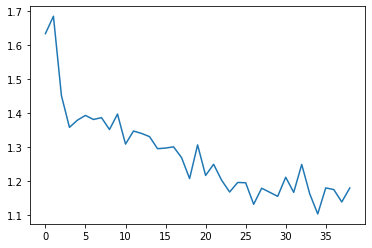

In [ ]:
plt.plot(loss_col)

In [ ]:
logr_coefs = {'x_sig': 0.03, 'y_sig': 0.03, 'z_sig': 0.0, 'prob': -2.3}
def log_reg(df, weights={}):
    
    df = df.copy()
    df['score'] = 0
    for k in weights:
        df['score'] += weights[k] * df[k]
    df['score'] = 1/(1 + np.exp(-df['score']))
    return df

(array([  85.,  440., 1634., 3826., 5908., 5951., 3874., 1606.,  417.,
          94.]),
 array([-50., -30., -10.,  10.,  30.,  50.,  70.,  90., 110., 130., 150.],
       dtype=float32),
 <BarContainer object of 10 artists>)

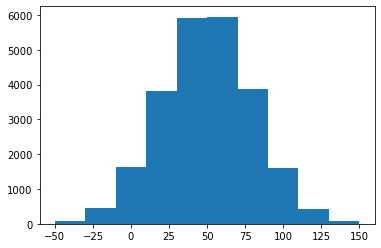

In [ ]:
plt.hist(cpu(torch.clamp(torch.randn(len(sim_vars[4])) * 30 + 50, -50, 150)))

In [ ]:
gt_dfs = []
pred_dfs = []

for i in tqdm(range(10)):
    
    with torch.no_grad():

        ret_dict = next(iter(decode_dl))
        x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'], 
        zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
        background = background * micro.get_ch_mult()
        local_rate *= 4
        if cfg.genm.microscope.col_shifts_enabled  :
            zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
            zcrop, ycrop, xcrop = zcrop.flatten(), ycrop.flatten(), xcrop.flatten()
            colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
        else:
            zcrop, ycrop, xcrop, colshift_crop = None, None, None, None

        sim_vars = point_process.sample(local_rate[:,0])
        
        ch_inp = list(micro.get_single_ch_inputs(*sim_vars[:-1], ycrop=ycrop, xcrop=xcrop))
        cond = sim_vars[-1] < len(codebook)
        cb_cool = torch.repeat_interleave(cond, cond * (cfg.genm.exp_type.n_bits - 1) + 1)
        ch_inp[1][cb_cool], ch_inp[2][cb_cool], ch_inp[3][cb_cool] = add_pos_noise([ch_inp[1][cb_cool], ch_inp[2][cb_cool], ch_inp[3][cb_cool]], 
                                                                                   [cfg.genm.pos_noise.pos_noise_xy*0.5, cfg.genm.pos_noise.pos_noise_xy*0.5, cfg.genm.pos_noise.pos_noise_z], cfg.genm.exp_type.n_bits)
        xsim = micro(*ch_inp, add_noise=True)
        
        if cfg.genm.phasing:

            phasing_inp = list(micro.get_single_ch_inputs(*sim_vars[:4], get_phased_ints(sim_vars[4], micro.ch_cols, micro.psf.n_cols) ,sim_vars[5], ycrop=ycrop, xcrop=xcrop))
            phasing_inp[1:4] = add_pos_noise(phasing_inp[1:4], [cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_z], cfg.genm.exp_type.n_bits, rm_mean=False)
            xsim += micro(*phasing_inp, add_noise=True) * cfg.genm.phasing * torch.rand(xsim.shape, device=xsim.device)

        x = micro.noise(xsim, background, randomize_range=cfg.genm.exp_type.randomize_noise_range).sample()

        colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
        net_inp = torch.concat([x,colshift_crop], 1)
        
        gt_vars = sim_vars[:-2] 
        gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])
        gt_df = gt_df[gt_df['code_inds'] < len(codebook)]

        res_dict = model(net_inp.cuda())
        res_dict = model.tensor_to_dict(res_dict)
        pred_df = post_proc.get_df(res_dict)
        pred_df = pred_df[pred_df['code_inds'] < len(codebook)]
        pred_df['gene'] = targets[pred_df['code_inds']]
        
        perf, matches, _ = matching(px_to_nm(gt_df), pred_df, tolerance=500, print_res=False)
        
        pred_df.loc[:, 'class'] = 1
        pred_df.loc[pred_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0
        
        pred_df = log_reg(pred_df, logr_coefs)
        
        pred_dfs.append(pred_df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:54<00:00, 11.49s/it]


In [ ]:
net.eval()
res_df = cat_emitter_dfs(pred_dfs, decode_dl.batch_size)
pred_zeroed = zero_int_ch(res_df, codebook)
res_df['int_ratio'] = pred_zeroed['int_ratio'].values
res_df['tot_int'] = pred_zeroed['tot_int'].values
res_df['tot_int_0bit'] = pred_zeroed['tot_int_0bit'].values
res_df['tot_int_sig'] = pred_zeroed['tot_int_sig'].values
inp = input_from_df(res_df, codebook)
# inp[:,-22:] *= 0
res_df['net_score'] = cpu(torch.sigmoid(net(inp)))

In [ ]:
res_df = sel_int_ch(res_df, codebook)

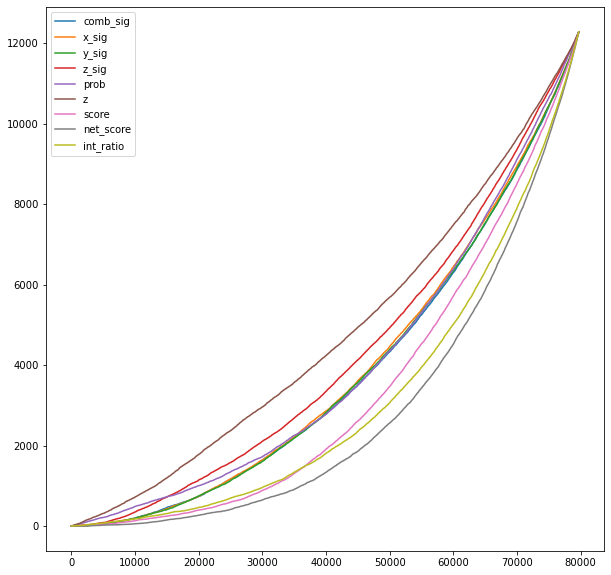

In [ ]:
plt.figure(figsize=(10,10))
for k in ['comb_sig','x_sig','y_sig','z_sig','prob','z','score','net_score','int_ratio']:
    b = False if k in ['tot_int','prob'] else True
    r  = make_roc(res_df, k, ascending=b)
    plt.plot(r, label=k)
plt.legend()

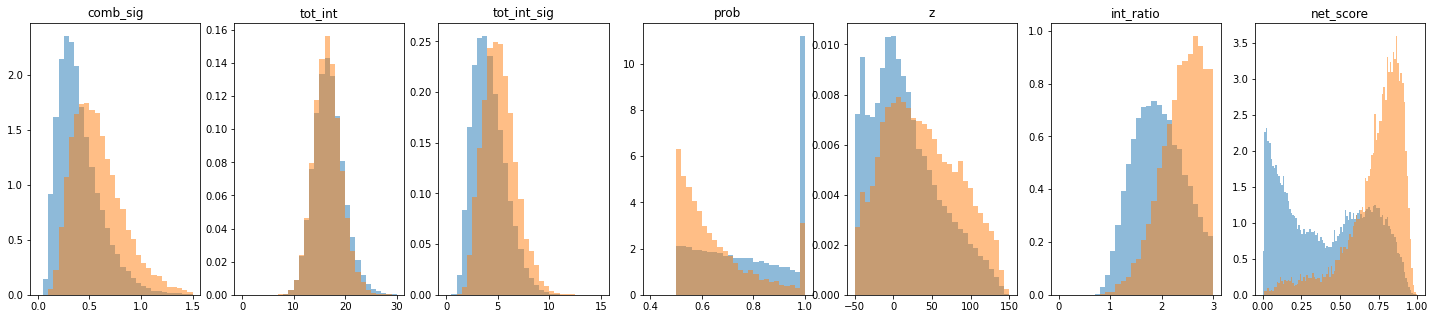

In [ ]:
# res_df = sel_int_ch(res_df, codebook)
metrics = ['comb_sig','tot_int','tot_int_sig', 'prob','z', 'int_ratio', 'net_score']
bins = [np.linspace(0,1.5,31), np.linspace(0,30,31), np.linspace(0,15,31), np.linspace(0.4,1,31), np.linspace(-50,150.,31),  np.linspace(0.,3., 31), np.linspace(0.,1., 101)]
plt.figure(figsize=(25,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(res_df[res_df['class'] == 0][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(res_df[res_df['class'] == 1][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

In [ ]:
plt.figure(figsize=(10,10))
for k in ['comb_sig','x_sig','y_sig','z_sig','prob','z','score','net_score','int_ratio']:
    b = False if k in ['tot_int','prob'] else True
    r  = make_roc(res_df, k,  ascending=b)
    plt.plot(r[0],r[1], label=k)
plt.legend()

TypeError: make_roc() got an unexpected keyword argument 'n_max'

<Figure size 720x720 with 0 Axes>

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_matching.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted 25_ensembling.ipynb.
Converted 26_gen_train.ipynb.
Converted 27_testtime_rescale.ipynb.
Converted index.ipynb.
